In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 73.2 MB/s 


## Imports

In [43]:
from transformers import AutoFeatureExtractor, VanForImageClassification
from transformers import AutoModelForImageClassification
import numpy as np
import torch
from torch import nn
from PIL import Image

## Model definition

In [61]:
class GlassProbaPredictor(nn.Module):
    """
    Загружает предобученную на ImageNet-1k (или на другом датасете, содержащем очки) модель с huggingface
    Предсказывает вероятность нахождения на фото очков
    """

    glasses_class = None  # Класс очков

    def __init__(
            self, 
            hf_model_name: str,
            glasses_class_name: str = 'sunglasses, dark glasses, shades',
            ):
        """
        hf_model_name: str
            Название предобученной модели на huggingface (например 'microsoft/resnet-50')
        glasses_class_name
            Название класса очков в датасете, на котором обучалась модель (по умолчанию используется название из ImageNet-1k)
        """
        
        super().__init__()

        self.feature_extractor = AutoFeatureExtractor.from_pretrained(hf_model_name)
        self.model = AutoModelForImageClassification.from_pretrained(hf_model_name)
        self.glasses_class = self.model.config.label2id[glasses_class_name]

    def forward(self, x):
        inputs = self.feature_extractor(x, return_tensors="pt")
        logits = self.model(**inputs).logits
        return logits

    def predict_proba(self, x):
        """
        Предсказать вероятность нахождения на фото очков
        """
        with torch.no_grad():
            pred = self(x).softmax(1)

        glass_prob = pred[0, self.glasses_class].item()
        return glass_prob

In [62]:
model_names = ['microsoft/resnet-50', 'Visual-Attention-Network/van-base']

model_name = model_names[1]

model = GlassProbaPredictor(model_name)

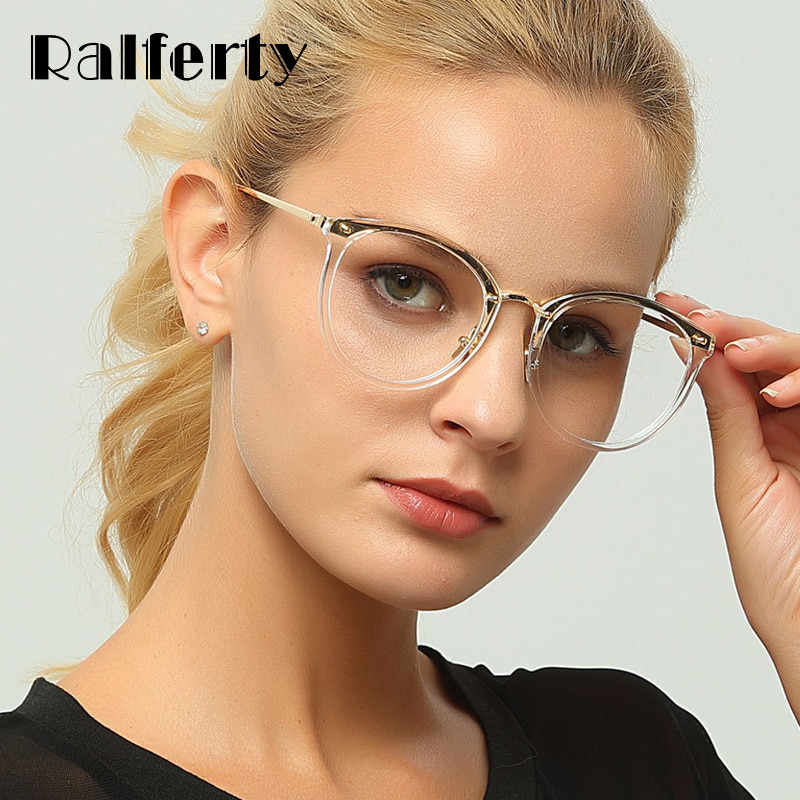

In [9]:
import urllib.request
img_fp = 'img.jpeg'

urllib.request.urlretrieve(
    'https://ae01.alicdn.com/kf/HTB14bHeBLuSBuNkHFqDq6xfhVXav/Ralferty-Transparent-Glasses-Trendy-Eyeglass-Woman-Frame-Female-Optic-Frames-Clear-Lens-Eyewear-Accessories-oculos-de.jpg', 
    img_fp
)
im = Image.open(img_fp)
im

In [51]:
glass_prob = model.predict_proba(np.array(im))

print(f'Glasses prob: {glass_prob:.2f}')

Glasses prob: 0.18
